# RBC sampling notebooks
 0.0.1 --> 14 feb (happy valentines day) starting different sampling modes
 

In [4]:
import os
import re
import warnings
# from cobra.io import *
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import altair as alt
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa,  qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile, plot_ensemble_phase_portrait, plot_ensemble_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
import csv
from minspan.minspan import minspan,nnz
from mass.io import json, sbml

mass_config = MassConfiguration()

mass_config.irreversible_Keq = float("inf")
# from minspan import minspan,nnz

MASSpy version: 0.1.6


In [5]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [6]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
sampling_dir = os.path.abspath("Sampling")
model_dir = os.path.abspath("models")


### Fetching MASS model

In [7]:
rbc_glyco = os.path.join(model_dir,"rbc_glyco.json")
glycolysis = json.load_json_model(rbc_glyco)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-02


### Running Concentration QP

In [8]:
ic_info = pd.DataFrame()
met_list =[]
met_conc = []
print("Initial Conditions\n------------------")
for metabolite, ic_value in glycolysis.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))
    met_list.append(str(metabolite))
    met_conc.append(ic_value)

ic_info["metabolite"] = met_list
ic_info["concentrations"] = met_conc
ic_info=ic_info.set_index('metabolite')
ic_info

Initial Conditions
------------------
glc__D_c: 1.0
g6p_c: 0.0486
f6p_c: 0.0198
fdp_c: 0.0146
dhap_c: 0.16
g3p_c: 0.00728
_13dpg_c: 0.000243
_3pg_c: 0.0773
_2pg_c: 0.0113
pep_c: 0.017
pyr_c: 0.060301
lac__L_c: 1.36
nad_c: 0.0589
nadh_c: 0.0301
amp_c: 0.0867281
adp_c: 0.29
atp_c: 1.6
pi_c: 2.5
h_c: 8.99757e-05
h2o_c: 1


,concentrations
metabolite,
glc__D_c,1.000000
g6p_c,0.048600
f6p_c,0.019800
fdp_c,0.014600
dhap_c,0.160000
g3p_c,0.007280
_13dpg_c,0.000243
_3pg_c,0.077300
_2pg_c,0.011300


In [9]:
for metabolite in [
    # "h_c", 
"h2o_c"]:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [10]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    'nadh_c',
    'nad_c',
    'h2o_c']:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [15]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    glycolysis,
    constraint_buffer=1)
conc_solver.solver = conc_solver.choose_solver(qp=True)


max


In [11]:

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycolysis.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

mass\util\util.py:159 UserWarning: Unrecognized kwargs: ['Keq_percent_deviation']
mass\thermo\conc_solution.py:98 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
mass\thermo\conc_solution.py:99 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,variables,reduced_costs
glc__D_c,1.000000,0.0
g6p_c,0.067683,0.0
f6p_c,0.014217,0.0
fdp_c,0.018619,0.0
dhap_c,0.162295,0.0
...,...,...
Keq_PGK,2395.642096,0.0
Keq_PGM,0.254843,0.0
Keq_ENO,2.452689,0.0
Keq_PYK,380699.574059,0.0


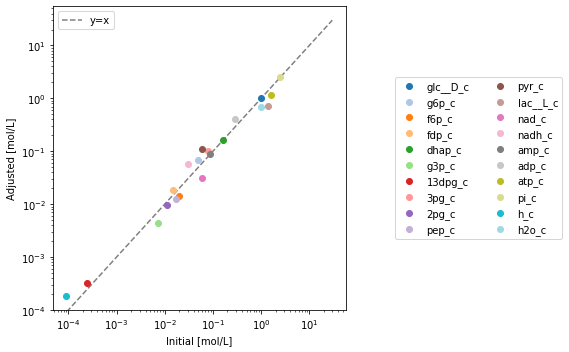

In [12]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=ic_info["concentrations"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in ic_info.index], ax=ax,
    legend="right outside", plot_function="loglog",
    # xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()


In [18]:
# update_model_with_concentration_solution(
#     glycolysis, conc_solution, concentrations=True, inplace=True);

In [19]:
conc_solution_adjusted = conc_solution.to_frame()
conc_fig_df = pd.DataFrame()
conc_fig_df["Initial"] = ic_info["concentrations"]
conc_fig_df["Adjusted"] = conc_solution_adjusted["variables"]
conc_fig_df["Metabolite"] = ic_info.index

mass\thermo\conc_solution.py:98 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
mass\thermo\conc_solution.py:99 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [20]:
conc_fig_comp = alt.Chart(conc_fig_df).mark_circle(size= 100).encode(
    alt.X("Initial", axis=alt.Axis( tickCount=0), scale=alt.Scale(type='log')),
    alt.Y('Adjusted',axis=alt.Axis( tickCount=5), 
    scale=alt.Scale(type='log')), 

    alt.Color('Metabolite', scale=alt.Scale(scheme='turbo')), 
    tooltip=['Metabolite', "Initial", "Adjusted"]
).properties(
    width=400,
    height=400).interactive()
conc_fig_comp

alt.Chart(...)

Caluclation of percs

In [28]:
percs = glycolysis.calculate_PERCs(update_reactions=True)

percs_df = pd.DataFrame()
print("Forward Rate Constants\n----------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

percs_df = pd.DataFrame.from_dict(percs, orient='index', columns = ["OG"])


Forward Rate Constants
----------------------
kf_HEX1: 0.978329
kf_PGI: 26.177931
kf_PFK: 68.917047
kf_FBA: 91.989074
kf_TPI: 10.794445
kf_GAPD: 4291.312229
kf_PGK: 29487.028034
kf_PGM: 36.477347
kf_ENO: 513.928049
kf_PYK: 466.473991
kf_LDH_L: 1274.950957
kf_DM_amp_c: 0.161424
kf_ADK1: 100000.000000
kf_SK_pyr_c: 744.186047
kf_SK_lac__L_c: 5.600000
kf_ATPM: 1.956604
kf_DM_nadh: 8.523509
kf_SK_glc__D_c: 1.120000
kf_SK_amp_c: 0.014000
kf_SK_h_c: 3.078914
kf_SK_h2o_c: 100000.000000


### Perc sampling

In [29]:
seed = int(1)
n_models = 1500

first trying with 1 order of magnitude

In [30]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycolysis.fixed),
    # fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    )
bound_mag = 5
for variable in conc_solver.variables:
    try:
        met = glycolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / bound_mag, met.ic * bound_mag])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models,  processes=4, seed=seed)
conc_samples.head()


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpf8fbvf7m.lp
Reading time = 0.00 seconds
: 20 rows, 42 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpz7t8mqwd.lp
Reading time = 0.00 seconds
: 11 rows, 31 columns, 53 nonzeros


,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,pyr_c,lac__L_c,nad_c,nadh_c,amp_c,adp_c,atp_c,pi_c,h_c,h2o_c
0,2.462065,0.297164,0.005629,0.005994,0.114823,0.000983,0.000110,0.078778,0.006477,0.011417,0.200404,2.382247,0.180226,0.014906,0.034759,0.330271,0.467465,0.617762,0.184012,0.313181
1,2.242641,0.308981,0.036277,0.013779,0.098502,0.002192,0.000287,0.083724,0.005458,0.012210,0.122339,0.437371,0.078217,0.007171,0.023136,0.928193,0.479299,0.682557,0.192961,0.275982
2,2.031364,0.190062,0.034682,0.005382,0.045065,0.001240,0.000117,0.033540,0.002688,0.006492,0.123787,0.456632,0.096068,0.013526,0.049200,1.815705,1.117184,0.850535,0.255071,0.307006
3,1.877906,0.205045,0.032162,0.013293,0.107946,0.001950,0.000236,0.100210,0.007642,0.012459,0.158813,1.049436,0.117241,0.032722,0.059031,0.781503,1.455357,2.617723,0.528624,0.316691
4,1.143786,0.182102,0.007715,0.054211,0.253607,0.004516,0.000461,0.118603,0.005564,0.009716,0.222136,0.654076,0.157525,0.017617,0.026267,1.622259,0.997164,2.998693,0.673409,0.176744


In [31]:
boundary_metabolites = []
for m in glycolysis.boundary:
    for i in (m.metabolites.keys()):
        if str(i) not in boundary_metabolites:
            boundary_metabolites.append(str(i))
            print(i)

amp_c
pyr_c
lac__L_c
glc__D_c
h_c
h2o_c


In [32]:
metabolite_ids = [m.id for m in glycolysis.metabolites]
misbalance= pd.DataFrame(
    glycolysis.S.dot(np.array(list(glycolysis.steady_state_fluxes.values()))),
    index=metabolite_ids,
    columns=[r"$\textbf{Sv}_{\mathrm{stst}}$"])
misbalance.T

,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,pyr_c,lac__L_c,nad_c,nadh_c,amp_c,adp_c,atp_c,pi_c,h_c,h2o_c
$\textbf{Sv}_{\mathrm{stst}}$,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.665335e-16,0.0,-1.665335e-16,1.665335e-16,0.0,0.0,0.0,0.0,4.440892e-16,0.0


In [33]:
# Determine imbalances in the reduced network
fluxes = np.array(list(glycolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    met = glycolysis.metabolites.get_by_id(mid)
    if imbalance != 0:
        if str(mid) not in boundary_metabolites:
            print(mid)

nad_c
nadh_c


In [39]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)
        if str(mid) not in boundary_metabolites:
            # print(mid)
            # Add boundary reactions for imbalanced metabolites
            boundary_type = "sink"    
            # Add boundary reaction with imbalance as flux value
            boundary_reaction = new_model.add_boundary(
                mid, boundary_type, boundary_condition=met.ic)

            boundary_reaction.Keq = 1
            if imbalance < 0:
                boundary_reaction.reverse_stoichiometry(inplace=True)
                imbalance = -imbalance

            boundary_reaction.kf = imbalance / met.ic
            boundary_reaction.steady_state_flux = imbalance
            try:
                # Update PERCs
                percs = new_model.calculate_PERCs(
                    fluxes={
                        r: v for r, v in new_model.steady_state_fluxes.items()
                        if not r.boundary},
                    update_reactions=True)
            except:
                print("Negative PERCs for {0}".format(new_model.id))
                continue




    df_p = pd.DataFrame.from_dict(percs, orient='index')
    df_p.columns = [("No."+ str(idx))]
    percs_df = pd.merge(percs_df, df_p, how='inner', left_index=True, right_index=True)




        
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpgav3j0nl.lp
Reading time = 0.00 seconds
: 20 rows, 42 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpe67c4xc1.lp
Reading time = 0.00 seconds
: 20 rows, 42 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpuxztr7b9.lp
Reading time = 0.01 seconds
: 11 rows, 31 columns, 53 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpm1l80ltf.lp
Reading time = 0.00 seconds
: 20 rows, 42 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp2a3y29vt.lp
Reading time = 0.00 seconds
: 20 rows, 42 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmphea8yvpx.lp
Reading time = 0.00 seconds
: 11 rows, 31 columns, 53 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpgac_7y_i.lp
Reading time = 0.00 seconds
: 20 rows, 42 columns, 120 non

#### Trying to simulate

In [47]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass

In [40]:
# Set the logger
from mass.util.util import (
    _check_kwargs,
    _log_msg,
    _make_logger,
    apply_decimal_precision,
    ensure_iterable,
)
MASSCONFIGURATION = MassConfiguration()
# If working in Python application (e.g. iPython notebooks), enable logging

# Set the logger
import roadrunner
LOGGER = _make_logger(__name__)

"""logging.Logger: Logger for :mod:`~mass.simulation.simulation` submodule."""


RR_LOGGER = roadrunner.Logger

"""roadrunner.Logger: The logger for the :mod:`roadrunner`."""
RR_LOGGER.disableLogging()

In [41]:
percs = glycolysis.calculate_PERCs(update_reactions=True)
percs_df_sim = pd.DataFrame.from_dict(percs, orient='index', columns = ["OG"])

In [55]:
# mass_config.processes = 10
mass_config.processes

7

In [59]:
# # Ensure all models are simulated to a long time and that
# # there are enough time points to determine if model reached steady state.
# tfinal = 1e4
# verbose = False
# sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
# sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
# sim.integrator.absolute_tolerance = 1e-15
# sim.integrator.relative_tolerance = 1e-9

# models_to_export = []
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     for model in models_for_ensemble:
#         # Attempt to determine steady state
#         conc_sol, flux_sol = sim.find_steady_state(
#             models=model, strategy="simulate", update_values=True,
#             tfinal=tfinal, 
#             verbose=verbose)
#         if conc_sol and flux_sol:
#             continue
#         print(str(model) + " first attempt failed.")
#         # First attempt was not successful, lengthen time for second attempt
#         # Attempt to determine steady state
#         conc_sol, flux_sol = sim.find_steady_state(
#             models=model, strategy="simulate", update_values=True,
#             tfinal=tfinal * 10, 
#             verbose=verbose)
#         if conc_sol and flux_sol:
#             continue
#         print(str(model) + " second attempt failed.")
#         # Second attempt was not successful, lengthen time for second attempt
#         # Attempt to determine steady state
#         conc_sol, flux_sol = sim.find_steady_state(
#             models=model, strategy="simulate", update_values=True,
#             tfinal=tfinal * 100, 
#             verbose=verbose)
        
#         if conc_sol and flux_sol:
#             sim_percs = pd.DataFrame()
#             for r in model.reactions:
#                 sim_percs.loc[len(sim_percs.index)] = [r.id, r.kf]
#                 sim_percs.columns = [("No."+ str(model))]
#             percs_df_sim = pd.merge(percs_df_sim, sim_percs, how='inner', left_index=True, right_index=True)
#             continue
#         print(str(model) + " third attempt failed. Eliminating model.")
#         # Third attempt was not successful, eliminate the model
#         sim.remove_models(models=model, verbose=verbose)

In [58]:
percs_df_sim

,OG
kf_HEX1,0.978329
kf_PGI,26.177931
kf_PFK,68.917047
kf_FBA,91.989074
kf_TPI,10.794445
kf_GAPD,4291.312229
kf_PGK,29487.028034
kf_PGM,36.477347
kf_ENO,513.928049
kf_PYK,466.473991


In [111]:
from mass.io.sbml import write_sbml_model
# from table_export import export_csv_files_for_models

In [110]:
models_to_export = sim.get_model_objects(models=sim.models)
for model in models_to_export:
    # Save as JSON
    save_json_mass_model(
        mass_model=model,
        filename=os.path.abspath(
            os.path.join(
                model_dir, "JSON", model.id + ".json")))
    # Save as SBML
    write_sbml_model(
        mass_model=model,
        filename=os.path.abspath(
            os.path.join(
                model_dir, "SBML", model.id + ".xml.zip")))
# Export tables
export_csv_files_for_models(
    models_to_export)
print("Number of models exported: {0:d}".format(len(sim.models)))

Number of models exported: 1326


### Forming Percs Dataframe

In [48]:
percs_df.index.names = ['RXN']
percs_df

,OG,No.0_x,No.1_x,No.2_x,No.3_x,No.4_x,No.5_x,No.6_x,No.7_x,No.8_x,...,No.1490,No.1491,No.1492,No.1493,No.1494,No.1495,No.1496,No.1497,No.1498,No.1499
RXN,,,,,,,,,,,,,,,,,,,,,
kf_HEX1,0.978329,0.973224,1.042289,0.493609,0.409831,0.982289,2.667429,2.254463,2.375888,1.530701,...,4.634920,10.826329,11.288520,4.136933,3.212869,5.490068,6.823375,1.826034,1.185003,1.252859
kf_PGI,26.177931,3.898289,4.563110,8.660487,7.530980,6.643317,14.241581,26.117870,47.123120,4.779116,...,5.401454,13.069690,15.338139,8.174113,10.821576,5.373273,10.166994,9.791077,4.190084,26.448112
kf_PFK,68.917047,426.662025,64.566369,28.930041,23.945466,151.153546,131.399542,91.742215,102.653427,52.181695,...,54.168842,192.608918,301.126792,138.625329,78.662477,68.830205,94.399183,37.946373,48.408690,142.015570
kf_FBA,91.989074,226.232764,95.052728,230.218524,98.709644,25.673284,42.337688,20.329142,87.570508,31.654368,...,28.604128,25.245830,44.379232,39.803821,33.623452,13.267112,18.502000,44.370850,33.869543,164.941535
kf_TPI,10.794445,10.968198,15.965199,38.582660,13.538544,5.737178,6.397531,4.425135,26.121747,4.859168,...,2.834550,4.524456,6.516312,11.646027,7.185090,3.647299,3.859335,2.994853,2.759271,12.679337
kf_GAPD,4291.312229,75268.979272,133494.288392,92380.074271,10129.566310,1289.465249,1668.372031,476.486351,8072.496337,2767.660086,...,355.124898,591.727716,1073.306822,1440.429254,489.227678,1766.522545,749.680705,416.950359,3522.760731,2741.412918
kf_PGK,29487.028034,103920.146501,8954.926384,11355.673868,17660.363907,3197.901972,20865.541635,4099.079881,18039.296140,7824.221335,...,13140.642456,12350.535478,19324.429389,19499.043307,30695.782143,164120.432127,75661.770847,14531.028977,8911.596438,6212.082684
kf_PGM,36.477347,41.711658,35.787999,96.829614,31.716993,23.078591,9.999153,6.032988,48.916237,58.830021,...,88.327897,62.461480,52.248594,111.360615,37.965234,25.999490,16.703478,13.678714,16.683812,29.328499
kf_ENO,513.928049,1256.994855,5119.880408,120480.129122,889.416206,1427.708737,3098.480299,251.202685,1555.996510,1543.651802,...,2435.854809,2240.214685,2390.539995,2010.950416,1732.412272,1701.751674,678.119396,205.590240,240.388060,667.242512


In [262]:
csv_percs = os.path.join(data_dir,"rbc_percs_glyco.csv")
# percs_df.to_csv(csv_percs)

### Percs Workflow

Log transforming it

In [263]:
# csv_percs = os.path.join(data_dir,"percs_df.csv")
og_percs_df = pd.read_csv(csv_percs,index_col="RXN")
percs_df = og_percs_df.copy()
# csv_percs

In [264]:
data_log = np.log(percs_df)
data_log

,OG,No.0_x,No.1_x,No.2_x,No.3_x,No.4_x,No.5_x,No.6_x,No.7_x,No.8_x,...,No.1490,No.1491,No.1492,No.1493,No.1494,No.1495,No.1496,No.1497,No.1498,No.1499
RXN,,,,,,,,,,,,,,,,,,,,,
kf_HEX1,-0.021909,-0.027141,0.041420,-0.706011,-0.892011,-0.017870,0.981115,0.812912,0.865371,0.425726,...,1.533619,2.381981,2.423786,1.419955,1.167164,1.702941,1.920354,0.602147,0.169746,0.225428
kf_PGI,3.264917,1.360538,1.518004,2.158771,2.019025,1.893611,2.656166,3.262620,3.852764,1.564256,...,1.686668,2.570296,2.730342,2.100972,2.381542,1.681437,2.319147,2.281471,1.432721,3.275185
kf_PFK,4.232904,6.055992,4.167694,3.364881,3.175779,5.018296,4.878243,4.518983,4.631359,3.954732,...,3.992106,5.260662,5.707531,4.931775,4.365166,4.231643,4.547532,3.636174,3.879679,4.955937
kf_FBA,4.521670,5.421564,4.554432,5.439029,4.592183,3.245451,3.745678,3.012055,4.472444,3.454876,...,3.353551,3.228661,3.792772,3.683963,3.515224,2.585288,2.917879,3.792583,3.522516,5.105591
kf_TPI,2.379032,2.395000,2.770411,3.652803,2.605541,1.746967,1.855912,1.487301,3.262768,1.580867,...,1.041883,1.509497,1.874309,2.454965,1.972008,1.293987,1.350495,1.096895,1.014966,2.539974
kf_GAPD,8.364348,11.228823,11.801814,11.433667,9.223214,7.161983,7.419604,6.166439,8.996218,7.925758,...,5.872470,6.383047,6.978500,7.272696,6.192828,7.476768,6.619647,6.032967,8.167000,7.916229
kf_PGK,10.291706,11.551378,9.099959,9.337473,9.779078,8.070250,9.945854,8.318518,9.800308,8.964980,...,9.483465,9.421455,9.869125,9.878121,10.331881,12.008356,11.234028,9.584042,9.095109,8.734251
kf_PGM,3.596691,3.730781,3.577613,4.572953,3.456853,3.138905,2.302500,1.797242,3.890109,4.074652,...,4.481056,4.134550,3.956013,4.712774,3.636671,3.258077,2.815617,2.615841,2.814439,3.378560
kf_ENO,6.242083,7.136479,8.540886,11.699240,6.790565,7.263826,8.038667,5.526260,7.349871,7.341906,...,7.798053,7.714327,7.779275,7.606363,7.457270,7.439413,6.519323,5.325885,5.482255,6.503154


In [265]:
from scipy import stats
from sklearn import cluster, metrics, decomposition # these will be useful
import seaborn as sns
import sklearn

In [266]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

def PCA_cluster_plot(data, cluster_labels, ax = None):
    """
    Parameters:
        data: the pd.DataFrame of gene expression data
        cluster_labels: a pd.Series with a cluster label
            for each column of data
        ax: if None, draw a new figure. else, populate these axes.
    Returns:
        ax: the plt.axes object of a PCA plot labeled by cluster
    """
    
    # check for bad input
    if isinstance(cluster_labels, pd.Series):
        if not(cluster_labels.index.equals(data.columns)):
            raise ValueError('cluster_labels.index doesn\'t match data.columns')
    else:
        raise TypeError('cluster_labels isn\'t a pd.Series')
    
    # compute PCA, save as dataframe with condition labels
    # data_norm = stats.zscore(data, axis=1)
    data_norm = sklearn.preprocessing.normalize(data,norm='l2')
    data_pc = PCA().fit_transform(data_norm.T)
    data_pc = pd.DataFrame(data_pc, index = data.columns)
    
    # get the unique clusters (supports naming if desired)
    unique_clusters = np.sort(cluster_labels.unique())
    
    # prepare a long list of colors
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan',
              'black', 'salmon', 'chocolate', 'orange', 'gold', 'lawngreen',
              'turquoise', 'steelblue', 'navy', 'violet', 'deeppink',
              'firebrick', 'sandybrown','olivedrab','darkgreen', 'aqua',
              'slategray', 'blue', 'fuschia', 'pink']
    
    # this code only runs if you have a ton of labels
    while len(colors) < len(cluster_labels.unique()):
        colors = colors + colors
    
    # make the plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlabel('PC1', fontsize = 16)
    ax.set_ylabel('PC2', fontsize = 16)
    
    # iterate through each cluster label
    for clust, color in zip(unique_clusters, colors):
        
        # get the samples of this cluster
        samples = cluster_labels.index[cluster_labels == clust]
        
        # add to plot
        ax.scatter(data_pc.loc[samples, 0],
                   data_pc.loc[samples, 1],
                   label = clust, color = color)
    
    # add legend
    ax.legend(bbox_to_anchor = (1,0))
    for i in range(data_pc.shape[0]):
        plt.text(x=data_pc.iloc[i,0]-0.03,y=data_pc.iloc[i,1]+0.04,s=data_pc.index[i])
    return ax

In [267]:
import umap.umap_ as umap

In [268]:
data_log

,OG,No.0_x,No.1_x,No.2_x,No.3_x,No.4_x,No.5_x,No.6_x,No.7_x,No.8_x,...,No.1490,No.1491,No.1492,No.1493,No.1494,No.1495,No.1496,No.1497,No.1498,No.1499
RXN,,,,,,,,,,,,,,,,,,,,,
kf_HEX1,-0.021909,-0.027141,0.041420,-0.706011,-0.892011,-0.017870,0.981115,0.812912,0.865371,0.425726,...,1.533619,2.381981,2.423786,1.419955,1.167164,1.702941,1.920354,0.602147,0.169746,0.225428
kf_PGI,3.264917,1.360538,1.518004,2.158771,2.019025,1.893611,2.656166,3.262620,3.852764,1.564256,...,1.686668,2.570296,2.730342,2.100972,2.381542,1.681437,2.319147,2.281471,1.432721,3.275185
kf_PFK,4.232904,6.055992,4.167694,3.364881,3.175779,5.018296,4.878243,4.518983,4.631359,3.954732,...,3.992106,5.260662,5.707531,4.931775,4.365166,4.231643,4.547532,3.636174,3.879679,4.955937
kf_FBA,4.521670,5.421564,4.554432,5.439029,4.592183,3.245451,3.745678,3.012055,4.472444,3.454876,...,3.353551,3.228661,3.792772,3.683963,3.515224,2.585288,2.917879,3.792583,3.522516,5.105591
kf_TPI,2.379032,2.395000,2.770411,3.652803,2.605541,1.746967,1.855912,1.487301,3.262768,1.580867,...,1.041883,1.509497,1.874309,2.454965,1.972008,1.293987,1.350495,1.096895,1.014966,2.539974
kf_GAPD,8.364348,11.228823,11.801814,11.433667,9.223214,7.161983,7.419604,6.166439,8.996218,7.925758,...,5.872470,6.383047,6.978500,7.272696,6.192828,7.476768,6.619647,6.032967,8.167000,7.916229
kf_PGK,10.291706,11.551378,9.099959,9.337473,9.779078,8.070250,9.945854,8.318518,9.800308,8.964980,...,9.483465,9.421455,9.869125,9.878121,10.331881,12.008356,11.234028,9.584042,9.095109,8.734251
kf_PGM,3.596691,3.730781,3.577613,4.572953,3.456853,3.138905,2.302500,1.797242,3.890109,4.074652,...,4.481056,4.134550,3.956013,4.712774,3.636671,3.258077,2.815617,2.615841,2.814439,3.378560
kf_ENO,6.242083,7.136479,8.540886,11.699240,6.790565,7.263826,8.038667,5.526260,7.349871,7.341906,...,7.798053,7.714327,7.779275,7.606363,7.457270,7.439413,6.519323,5.325885,5.482255,6.503154


In [269]:
# data_norm = sklearn.preprocessing.normalize(data_log.T,norm='l2')
# data_umap = pd.DataFrame(data_norm.copy(), columns = [data_log.index])
data_umap = percs_df.T.copy()

data_umap

RXN,kf_HEX1,kf_PGI,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ADK1,kf_ATPM,kf_DM_nadh
OG,0.978329,26.177931,68.917047,91.989074,10.794445,4291.312229,29487.028034,36.477347,513.928049,466.473991,1274.950957,100000.0,1.956604,8.523509
No.0_x,0.973224,3.898289,426.662025,226.232764,10.968198,75268.979272,103920.146501,41.711658,1256.994855,594.086946,678.567808,100000.0,4.791800,15.027144
No.1_x,1.042289,4.563110,64.566369,95.052728,15.965199,133494.288392,8954.926384,35.787999,5119.880408,197.649870,2301.487807,100000.0,4.673493,31.238333
No.2_x,0.493609,8.660487,28.930041,230.218524,38.582660,92380.074271,11355.673868,96.829614,120480.129122,190.045907,1205.269030,100000.0,2.005042,16.560837
No.3_x,0.409831,7.530980,23.945466,98.709644,13.538544,10129.566310,17660.363907,31.716993,889.416206,230.080272,388.286300,100000.0,1.539142,6.845495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
No.1495,5.490068,5.373273,68.830205,13.267112,3.647299,1766.522545,164120.432127,25.999490,1701.751674,2928.938537,1739.727956,100000.0,8.483407,14.627274
No.1496,6.823375,10.166994,94.399183,18.502000,3.859335,749.680705,75661.770847,16.703478,678.119396,1407.775577,980.761577,100000.0,6.319587,12.704394
No.1497,1.826034,9.791077,37.946373,44.370850,2.994853,416.950359,14531.028977,13.678714,205.590240,113.657453,480.285143,100000.0,1.924822,15.255125
No.1498,1.185003,4.190084,48.408690,33.869543,2.759271,3522.760731,8911.596438,16.683812,240.388060,419.494053,1740.428503,100000.0,3.417408,14.303679


In [270]:
import plotly.express as px

Text(0.5, 1.0, 'UMAP projection of the PERCS dataset')

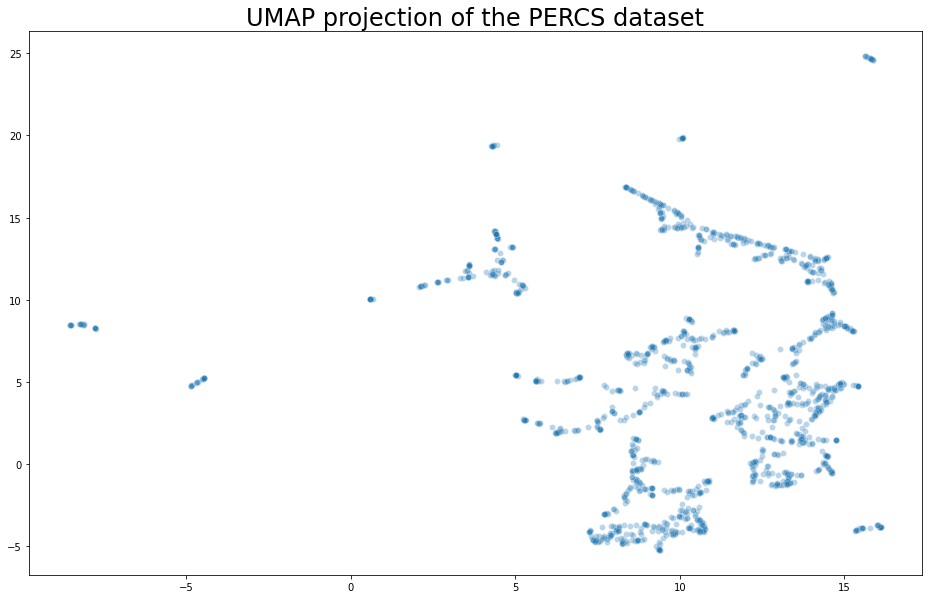

In [271]:
reducer = umap.UMAP(n_components=2, random_state = 42, n_neighbors=10)
embedding = reducer.fit_transform(data_umap)

dataframe_embedded = pd.DataFrame(embedding,
                         columns = [0,1], index = data_umap.T.columns)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=embedding[:,0], y=embedding[:,1],
    palette=sns.color_palette("hls", 10),
    data=data_umap,
    legend="full",
    alpha=0.3
)
plt.title('UMAP projection of the PERCS dataset', fontsize=24)

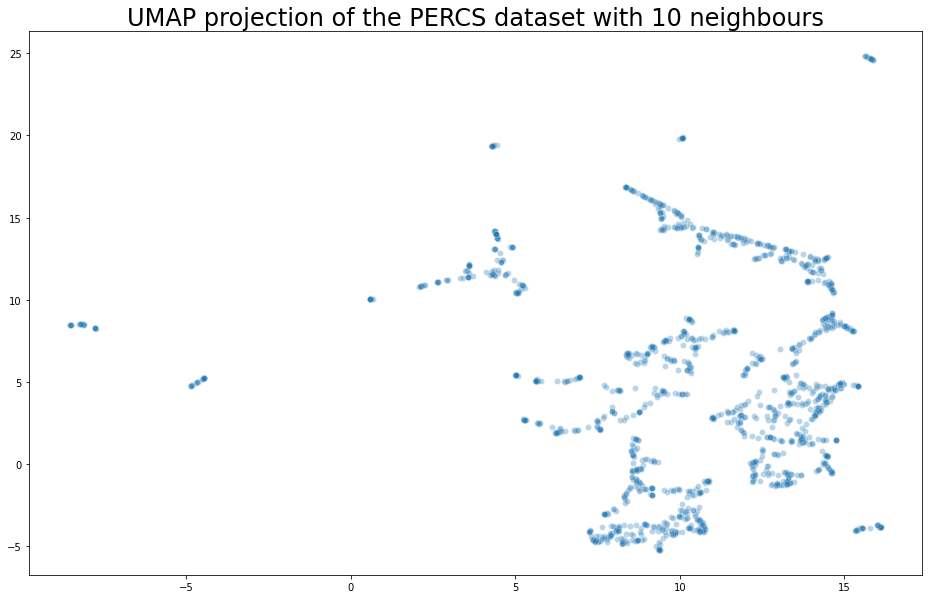

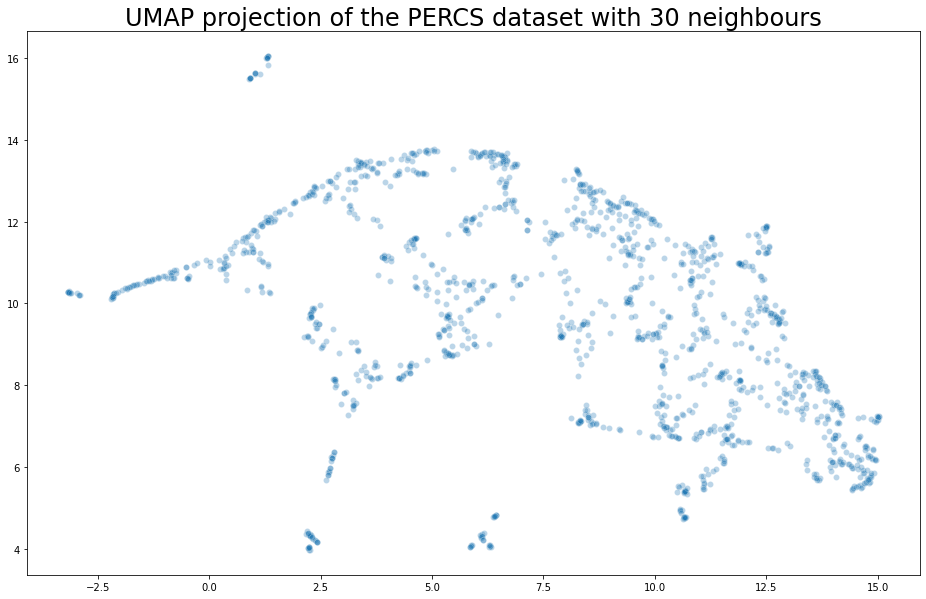

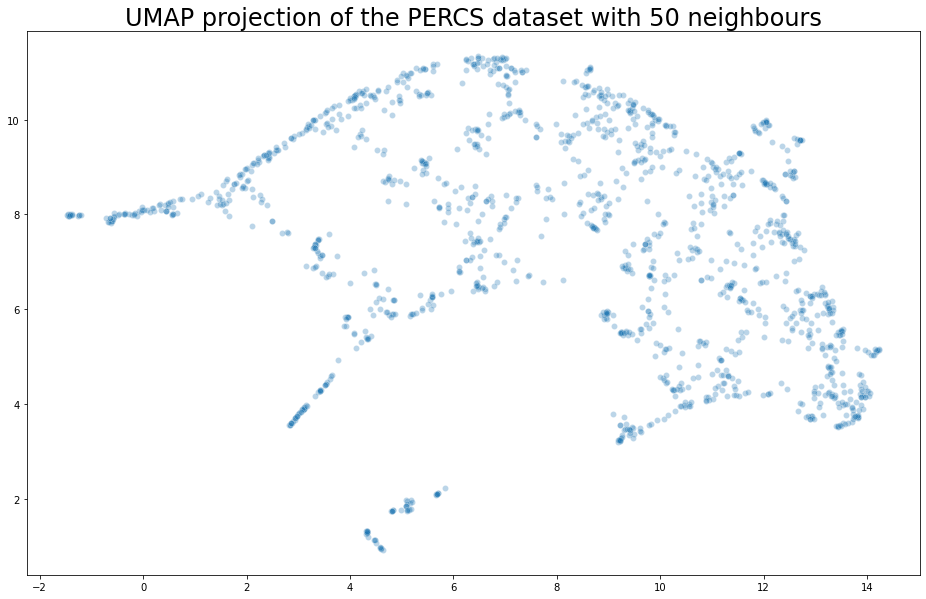

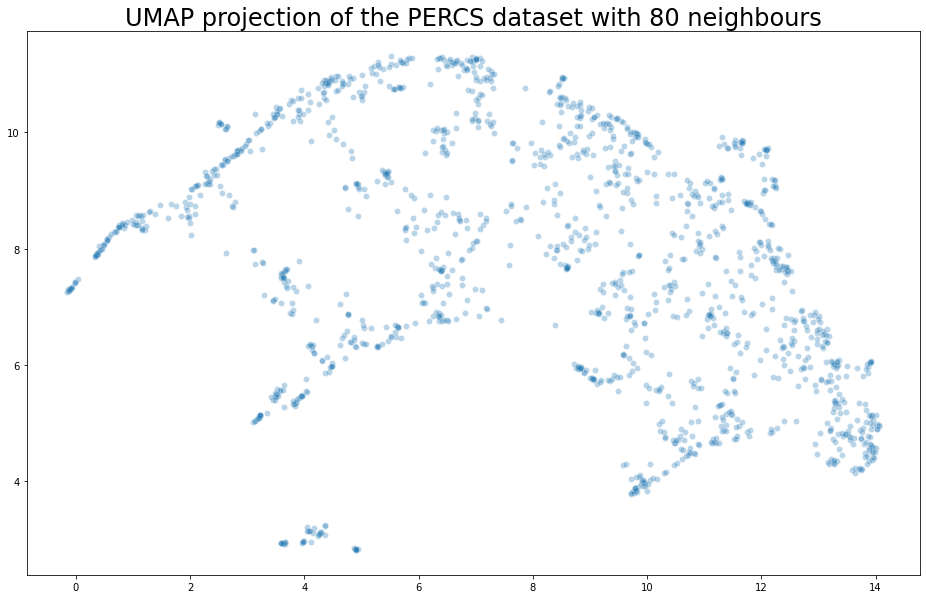

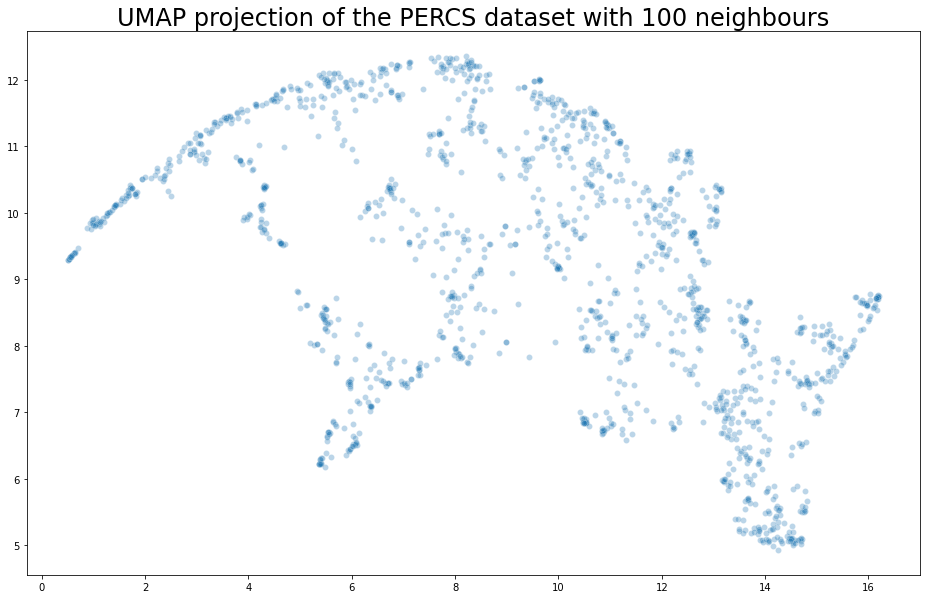

In [272]:
n_nieghbors = [10,30, 50, 80, 100]
for i in n_nieghbors:
    reducer = umap.UMAP(n_components=2, random_state = 42, n_neighbors=i)
    embedding = reducer.fit_transform(data_umap)

    dataframe_embedded = pd.DataFrame(embedding,
                            columns = [0,1], index = data_umap.T.columns)

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x=embedding[:,0], y=embedding[:,1],
        palette=sns.color_palette("hls", 10),
        data=data_umap,
        legend="full",
        alpha=0.3
    )
    plt.title('UMAP projection of the PERCS dataset with ' + str(i) + " neighbours", fontsize=24)

In [273]:
from sklearn.cluster import DBSCAN
# To determine the optimal ε parameter, I will compute the k-nearest neighbor (kNN) distances (average distance of every data point to its k-nearest neighbors) of an input dataset using 
# the k-nearest neighbor method (unsupervised nearest neighbors learning). 
# https://www.reneshbedre.com/blog/dbscan-python.html

In [274]:
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=5).fit(percs_df)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(percs_df)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

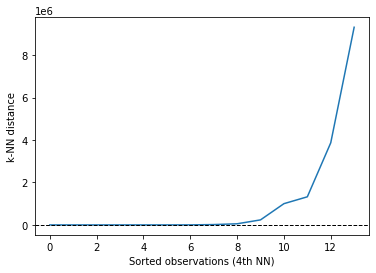

In [275]:
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=2.5, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [276]:
# create a DataFrame to store all the clusters
k_range = range(2, 13)
elbow_df = pd.DataFrame(index = data_log.index, 
                        columns = k_range)

# compute the clusters at each k
for k in k_range:
    
    # repeat code from problem 1.2.1
    k_clusters = cluster.KMeans(n_clusters = k, random_state = 1)
    k_clusters = k_clusters.fit(data_log)
    
    # store in DataFrame
    elbow_df[k] = k_clusters.labels_

In [277]:
db = DBSCAN(eps=0.8, min_samples=48).fit(embedding)
db.labels_

# db = DBSCAN(eps=0.8, min_samples=48).fit(embedding)
# db.labels_

array([1, 2, 3, ..., 0, 0, 0], dtype=int64)

In [278]:
set(db.labels_)
from collections import Counter
Counter(db.labels_)

Counter({1: 207, 2: 196, 3: 136, -1: 54, 0: 839, 4: 78})

In [279]:
len(Counter(db.labels_))

6

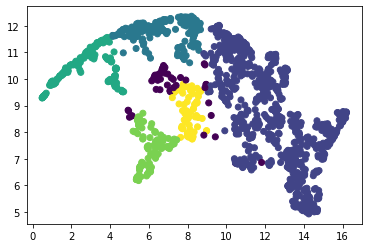

In [280]:
plt.scatter(embedding[:, 0], 
embedding[:, 1], 
c=db.labels_, 
# label=y
)
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")

In [281]:
db.labels_

array([1, 2, 3, ..., 0, 0, 0], dtype=int64)

In [282]:
embedding_2 = pd.DataFrame(embedding, columns = ["Col1", "Col2"])
embedding_2["labels"] = db.labels_
embedding_2

,Col1,Col2,labels
0,6.547413,12.058505,1
1,0.501361,9.290888,2
2,5.388921,6.244249,3
3,4.398027,9.619039,2
4,8.955960,9.793190,-1
...,...,...,...
1505,0.985606,9.818665,2
1506,1.752490,10.376314,2
1507,11.300405,10.993350,0
1508,12.175931,8.184980,0


In [1]:
alt.data_transformers.disable_max_rows()
fig = alt.Chart(embedding_2).mark_circle(size= 100).encode(
    alt.X("Col1", axis=alt.Axis( tickCount=5), 
        #   scale=alt.Scale(type='log')
          ),
    alt.Y('Col2',axis=alt.Axis( tickCount=5), 
    # scale=alt.Scale(type='log')
    ), 

    alt.Color('labels:N', scale=alt.Scale(scheme='darkblue')), 
    # tooltip=['RXN', "val"]
).properties(
    width=400,
    height=400).interactive()
fig

NameError: name 'alt' is not defined

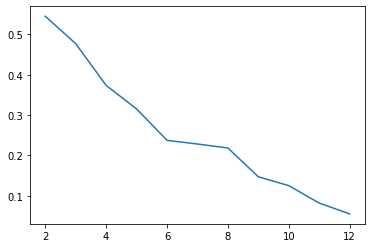

In [321]:
# compute the silhouette scores
k_silhouette = pd.Series(index = k_range, dtype=float)

for k in k_range:
    k_silhouette[k] = metrics.silhouette_score(data_log, elbow_df[k])
    
# plot
fig, ax = plt.subplots()
ax.plot(k_range, k_silhouette)

In [322]:
# mean_silhouette = pd.Series(index = k_range, dtype=float)

# # increase this number to make the curve smoother
# # requires a lot of time to run
# num_repeats = 10

# for k in k_range:
#     k_scs = []
#     for i in range(num_repeats):
#         # DO NOT specify a random state so we intentionally 
#         # get different results
#         k_clusters = cluster.KMeans(n_clusters = k)
#         k_clusters = k_clusters.fit(percs_df.T)
        
#         # add this silhouette score
#         k_scs += [metrics.silhouette_score(percs_df.T, k_clusters.labels_)]
    
#     # take the mean silhouette score
#     mean_silhouette[k] = np.mean(k_scs)

In [323]:
# X = percs_df
# distorsions = []
# for k in range(2, 14):
#     kmeans = cluster.KMeans(n_clusters=k)
#     kmeans.fit(X)
#     distorsions.append(kmeans.inertia_)

In [324]:
# fig, ax = plt.subplots()
# ax.plot(k_range, mean_silhouette)
# ax.set_xlabel('K')
# ax.set_ylabel('Mean Silhouette Score')


# # this reduces our k slightly
# best_k = 6
# ax.scatter(best_k, mean_silhouette[best_k], color = 'r', s = 50)

In [338]:
k10_clusters = cluster.KMeans(n_clusters = 5, random_state = 1)

# compute the clusters
# use the transpose of the data to get samples instead of genes
k10_clusters = k10_clusters.fit(data_log)

# label the output with condition names
k10_labels = pd.Series(k10_clusters.labels_, index = data_log.index)

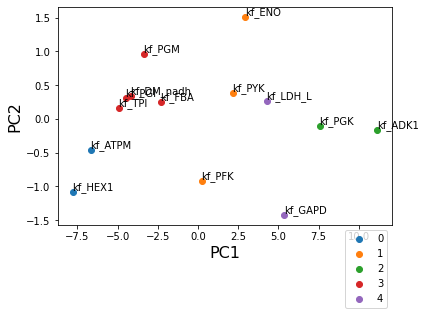

In [339]:
# ANSWER    

ax = PCA_cluster_plot(data_log.T, k10_labels)

In [340]:
data_norm = sklearn.preprocessing.normalize(data_log.T,norm='l2')
data_pc = PCA().fit_transform(data_norm.T)
data_pc = pd.DataFrame(data_pc, index = data_log.index)
plot_data = data_pc.iloc[:,0:2]
plot_data.columns = ["PC1", "PC2"]
# data_pc

In [341]:

plot_data["RXN"] = plot_data.index
plot_data["clusters"] = k10_labels
alt.data_transformers.disable_max_rows()
fig = alt.Chart(plot_data).mark_circle(size= 100).encode(
    alt.X("PC1", ),
    alt.Y('PC2' ), 

    alt.Color('clusters:N', scale=alt.Scale(scheme='category10')), 
    tooltip=['RXN']
).properties(
    width=600,
    height=400)
# .interactive()
text = fig.mark_text(
    align='left',
    baseline='top',
    dx=10
).encode(
    text='RXN'
)
fig+ text

C:\Users\sicil\AppData\Local\Temp\ipykernel_9560\644687385.py:1 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sicil\AppData\Local\Temp\ipykernel_9560\644687385.py:2 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


alt.LayerChart(...)

Clustering of samples and not reactions

In [309]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

def PCA_cluster_plot_without_labels(data, cluster_labels, ax = None):
    """
    Parameters:
        data: the pd.DataFrame of gene expression data
        cluster_labels: a pd.Series with a cluster label
            for each column of data
        ax: if None, draw a new figure. else, populate these axes.
    Returns:
        ax: the plt.axes object of a PCA plot labeled by cluster
    """
    
    # check for bad input
    if isinstance(cluster_labels, pd.Series):
        if not(cluster_labels.index.equals(data.columns)):
            raise ValueError('cluster_labels.index doesn\'t match data.columns')
    else:
        raise TypeError('cluster_labels isn\'t a pd.Series')
    
    # compute PCA, save as dataframe with condition labels
    # data_norm = stats.zscore(data, axis=1)
    data_norm = sklearn.preprocessing.normalize(data,norm='l2')
    data_pc = PCA().fit_transform(data_norm.T)
    data_pc = pd.DataFrame(data_pc, index = data.columns)
    
    # get the unique clusters (supports naming if desired)
    unique_clusters = np.sort(cluster_labels.unique())
    
    # prepare a long list of colors
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan',
              'black', 'salmon', 'chocolate', 'orange', 'gold', 'lawngreen',
              'turquoise', 'steelblue', 'navy', 'violet', 'deeppink',
              'firebrick', 'sandybrown','olivedrab','darkgreen', 'aqua',
              'slategray', 'blue', 'fuschia', 'pink']
    
    # this code only runs if you have a ton of labels
    while len(colors) < len(cluster_labels.unique()):
        colors = colors + colors
    
    # make the plot
    if ax is None:
        fig, ax = plt.subplots(figsize= (10,8))
    ax.set_xlabel('PC1', fontsize = 16)
    ax.set_ylabel('PC2', fontsize = 16)
    
    # iterate through each cluster label
    for clust, color in zip(unique_clusters, colors):
        
        # get the samples of this cluster
        samples = cluster_labels.index[cluster_labels == clust]
        
        # add to plot
        ax.scatter(data_pc.loc[samples, 0],
                   data_pc.loc[samples, 1],
                   label = clust, color = color)
    
    # add legend
    ax.legend(bbox_to_anchor = (1,1))
    # for i in range(data_pc.shape[0]):
        # plt.text(x=data_pc.iloc[i,0]-0.03,y=data_pc.iloc[i,1]+0.04,s=data_pc.index[i])
    return ax

In [310]:
data_log

,OG,No.0_x,No.1_x,No.2_x,No.3_x,No.4_x,No.5_x,No.6_x,No.7_x,No.8_x,...,No.1490,No.1491,No.1492,No.1493,No.1494,No.1495,No.1496,No.1497,No.1498,No.1499
RXN,,,,,,,,,,,,,,,,,,,,,
kf_HEX1,-0.021909,-0.027141,0.041420,-0.706011,-0.892011,-0.017870,0.981115,0.812912,0.865371,0.425726,...,1.533619,2.381981,2.423786,1.419955,1.167164,1.702941,1.920354,0.602147,0.169746,0.225428
kf_PGI,3.264917,1.360538,1.518004,2.158771,2.019025,1.893611,2.656166,3.262620,3.852764,1.564256,...,1.686668,2.570296,2.730342,2.100972,2.381542,1.681437,2.319147,2.281471,1.432721,3.275185
kf_PFK,4.232904,6.055992,4.167694,3.364881,3.175779,5.018296,4.878243,4.518983,4.631359,3.954732,...,3.992106,5.260662,5.707531,4.931775,4.365166,4.231643,4.547532,3.636174,3.879679,4.955937
kf_FBA,4.521670,5.421564,4.554432,5.439029,4.592183,3.245451,3.745678,3.012055,4.472444,3.454876,...,3.353551,3.228661,3.792772,3.683963,3.515224,2.585288,2.917879,3.792583,3.522516,5.105591
kf_TPI,2.379032,2.395000,2.770411,3.652803,2.605541,1.746967,1.855912,1.487301,3.262768,1.580867,...,1.041883,1.509497,1.874309,2.454965,1.972008,1.293987,1.350495,1.096895,1.014966,2.539974
kf_GAPD,8.364348,11.228823,11.801814,11.433667,9.223214,7.161983,7.419604,6.166439,8.996218,7.925758,...,5.872470,6.383047,6.978500,7.272696,6.192828,7.476768,6.619647,6.032967,8.167000,7.916229
kf_PGK,10.291706,11.551378,9.099959,9.337473,9.779078,8.070250,9.945854,8.318518,9.800308,8.964980,...,9.483465,9.421455,9.869125,9.878121,10.331881,12.008356,11.234028,9.584042,9.095109,8.734251
kf_PGM,3.596691,3.730781,3.577613,4.572953,3.456853,3.138905,2.302500,1.797242,3.890109,4.074652,...,4.481056,4.134550,3.956013,4.712774,3.636671,3.258077,2.815617,2.615841,2.814439,3.378560
kf_ENO,6.242083,7.136479,8.540886,11.699240,6.790565,7.263826,8.038667,5.526260,7.349871,7.341906,...,7.798053,7.714327,7.779275,7.606363,7.457270,7.439413,6.519323,5.325885,5.482255,6.503154


In [311]:
# k_range = range(2, 1499)
# inertia = pd.Series(index = k_range, dtype=float)

# for k in k_range:
#     k_clusters = cluster.KMeans(n_clusters = k, random_state = 1)
#     k_clusters = k_clusters.fit(data_log.T)
#     inertia[k] = k_clusters.inertia_

In [312]:
# fig, ax = plt.subplots()
# ax.plot(k_range, inertia)
# ax.set_xlabel('K')
# ax.set_ylabel('Inertia')

# best_k = 11
# ax.scatter(best_k, inertia[best_k], color = 'r', s = 50)

In [313]:

# mean_silhouette = pd.Series(index = k_range, dtype=float)

# # increase this number to make the curve smoother
# # requires a lot of time to run
# num_repeats = 10

# for k in k_range:
#     k_scs = []
#     for i in range(num_repeats):
#         # DO NOT specify a random state so we intentionally 
#         # get different results
#         k_clusters = cluster.KMeans(n_clusters = k)
#         k_clusters = k_clusters.fit(data_log.T)
        
#         # add this silhouette score
#         k_scs += [metrics.silhouette_score(data_log.T, k_clusters.labels_)]
    
#     # take the mean silhouette score
#     mean_silhouette[k] = np.mean(k_scs)

In [314]:

# fig, ax = plt.subplots()
# ax.plot(k_range, mean_silhouette)
# ax.set_xlabel('K')
# ax.set_ylabel('Mean Silhouette Score')


# # this reduces our k slightly
# best_k = 6
# ax.scatter(best_k, mean_silhouette[best_k], color = 'r', s = 50)

In [315]:
k10_clusters = cluster.KMeans(n_clusters =20, random_state = 1)

# compute the clusters
# use the transpose of the data to get samples instead of genes
k10_clusters = k10_clusters.fit(data_log.T)

# label the output with condition names
k10_labels = pd.Series(k10_clusters.labels_, index = data_log.columns)

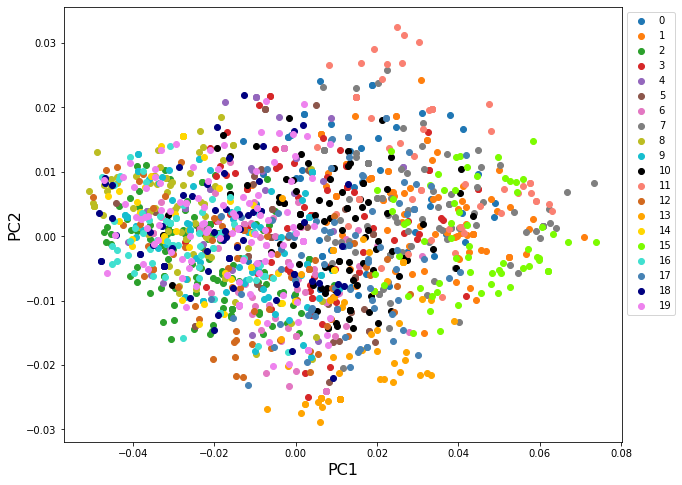

In [316]:
# ANSWER    

ax = PCA_cluster_plot_without_labels(data_log, k10_labels)

In [ ]:
data_norm = sklearn.preprocessing.normalize(data_log,norm='l2')
data_pc = PCA().fit_transform(data_norm.T)
data_pc = pd.DataFrame(data_pc, 
                       index = data_log.columns, 
                    # columns = data_log.index
                       )
data_pc
plot_data = data_pc.iloc[:,0:2]
plot_data.columns = ["PC1", "PC2"]
plot_data["samples"] = plot_data.index
plot_data["clusters"] = k10_labels
plot_data
alt.data_transformers.disable_max_rows()
fig = alt.Chart(plot_data).mark_circle(size= 100).encode(
    alt.X("PC1", ),
    alt.Y('PC2' ), 

    alt.Color('clusters', scale=alt.Scale(scheme='turbo')), 
    tooltip=['samples']
).properties(
    width=700,
    height=400).interactive()
# text = fig.mark_text(
#     align='left',
#     baseline='bottom',
#     dx=10
# ).encode(
#     text='samples'
# )
fig
# + text

C:\Users\sicil\AppData\Local\Temp\ipykernel_3696\745159171.py:10 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sicil\AppData\Local\Temp\ipykernel_3696\745159171.py:11 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


alt.Chart(...)

### Making distributions for percs

In [35]:
data_norm = sklearn.preprocessing.normalize(percs_df,norm='l2')
data_norm= pd.DataFrame(data_norm)
data_norm = data_norm.T
data_norm.columns = [data_log.index]
data_norm

RXN,kf_HEX1,kf_PGI,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ADK1,kf_ATPM,kf_DM_nadh
0,0.004371,0.029062,0.003945,0.029059,0.018186,0.000461,0.022217,0.024414,0.000513,0.008559,0.005347,0.025734,0.010101,0.010346
1,0.004348,0.004328,0.024420,0.071466,0.018479,0.008078,0.078297,0.027918,0.001254,0.010901,0.002846,0.025734,0.024738,0.018240
2,0.004657,0.005066,0.003696,0.030027,0.026898,0.014328,0.006747,0.023953,0.005108,0.003627,0.009653,0.025734,0.024127,0.037918
3,0.002205,0.009615,0.001656,0.072725,0.065003,0.009915,0.008556,0.064808,0.120200,0.003487,0.005055,0.025734,0.010351,0.020102
4,0.001831,0.008361,0.001371,0.031182,0.022809,0.001087,0.013306,0.021228,0.000887,0.004222,0.001629,0.025734,0.007946,0.008309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,0.024527,0.005965,0.003940,0.004191,0.006145,0.000190,0.123655,0.017401,0.001698,0.053744,0.007297,0.025734,0.043797,0.017755
1506,0.030484,0.011287,0.005403,0.005845,0.006502,0.000080,0.057007,0.011180,0.000677,0.025832,0.004114,0.025734,0.032626,0.015421
1507,0.008158,0.010870,0.002172,0.014017,0.005046,0.000045,0.010948,0.009155,0.000205,0.002086,0.002014,0.025734,0.009937,0.018517
1508,0.005294,0.004652,0.002771,0.010699,0.004649,0.000378,0.006714,0.011166,0.000240,0.007697,0.007300,0.025734,0.017643,0.017362


In [47]:
data_vis = percs_df.T.melt()
data_vis.columns = ["RXN", "val"]

In [48]:
alt.data_transformers.disable_max_rows()
fig = alt.Chart(data_vis).mark_circle(size= 100).encode(
    alt.X("RXN", axis=alt.Axis( tickCount=5), scale=alt.Scale(type='log')),
    alt.Y('val',axis=alt.Axis( tickCount=5), 
    scale=alt.Scale(type='log')), 

    alt.Color('RXN', scale=alt.Scale(scheme='turbo')), 
    tooltip=['RXN', "val"]
).properties(
    width=400,
    height=400).interactive()
fig

alt.Chart(...)

In [29]:
data_log
data_vis_log = data_log.T.melt()
data_vis_log.columns = ["RXN", "val"]
data_vis_log

,RXN,val
0,kf_HEX1,-0.021909
1,kf_HEX1,-0.027141
2,kf_HEX1,0.041420
3,kf_HEX1,-0.706011
4,kf_HEX1,-0.892011
...,...,...
21135,kf_DM_nadh,2.682888
21136,kf_DM_nadh,2.541948
21137,kf_DM_nadh,2.724916
21138,kf_DM_nadh,2.660517


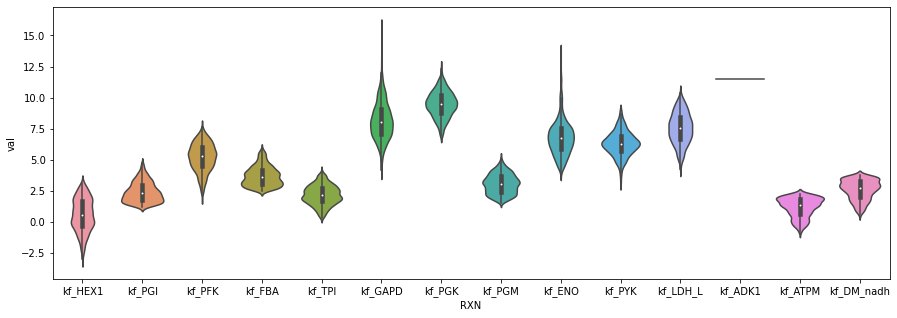

In [30]:
plt.figure(figsize= (15,5))
sns.violinplot(data=data_vis_log, 
               x = "RXN",
               y= "val" )


VP_sns = os.path.join(data_dir,"Violin_perc_glyco.png")
# Saving figure by changing parameter values
plt.savefig(VP_sns, pad_inches=0.3)
plt.show()

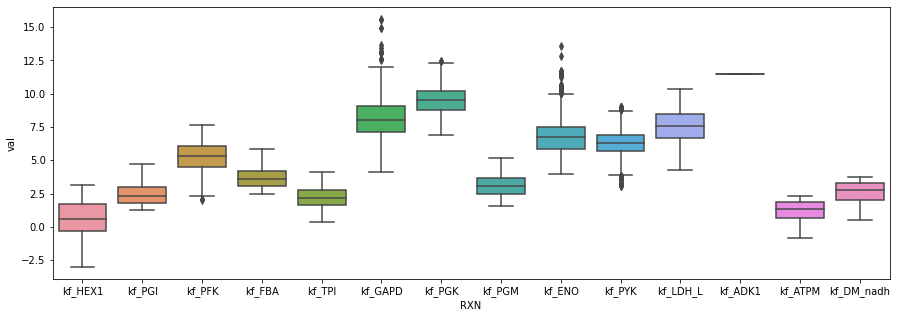

In [31]:
plt.figure(figsize= (15,5))
sns.boxplot(data=data_vis_log, 
               x = "RXN",
               y= "val" ,
            #    cut=0
            
               )


VP_sns = os.path.join(data_dir,"box_perc_dis_glyc.png")
# Saving figure by changing parameter values
plt.savefig(VP_sns, pad_inches=0.05)
plt.show()


In [63]:
# # Violin Plot of percs distribution without log tranforming
# alt.data_transformers.disable_max_rows()
# alt.Chart(data_vis).transform_density(
#     'val',
#     as_=['Value_column', 'density'],    
#     extent=[-0.1, 1000],
#     groupby=['RXN']
#     ).mark_area(orient='horizontal').encode(
#     y=alt.Y('Value_column:Q',axis=alt.Axis(grid=False,ticks=True)),
#     color='RXN:N',
#     x=alt.X('density:Q', stack='center',impute=None,
#         title=None,
#         axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True)),
#         tooltip=['RXN:N', "Value_column:Q"], 
#     column=alt.Column(
#         'RXN:N',header=alt.Header(
#             titleOrient='bottom',
#             labelOrient='bottom',
#             labelPadding=0))
# ).properties(
#     width=50).configure_facet(spacing=0).configure_view(stroke=None).interactive()

In [36]:
data_norm

RXN,kf_HEX1,kf_PGI,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ADK1,kf_ATPM,kf_DM_nadh
0,0.004371,0.029062,0.003945,0.029059,0.018186,0.000461,0.022217,0.024414,0.000513,0.008559,0.005347,0.025734,0.010101,0.010346
1,0.004348,0.004328,0.024420,0.071466,0.018479,0.008078,0.078297,0.027918,0.001254,0.010901,0.002846,0.025734,0.024738,0.018240
2,0.004657,0.005066,0.003696,0.030027,0.026898,0.014328,0.006747,0.023953,0.005108,0.003627,0.009653,0.025734,0.024127,0.037918
3,0.002205,0.009615,0.001656,0.072725,0.065003,0.009915,0.008556,0.064808,0.120200,0.003487,0.005055,0.025734,0.010351,0.020102
4,0.001831,0.008361,0.001371,0.031182,0.022809,0.001087,0.013306,0.021228,0.000887,0.004222,0.001629,0.025734,0.007946,0.008309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,0.024527,0.005965,0.003940,0.004191,0.006145,0.000190,0.123655,0.017401,0.001698,0.053744,0.007297,0.025734,0.043797,0.017755
1506,0.030484,0.011287,0.005403,0.005845,0.006502,0.000080,0.057007,0.011180,0.000677,0.025832,0.004114,0.025734,0.032626,0.015421
1507,0.008158,0.010870,0.002172,0.014017,0.005046,0.000045,0.010948,0.009155,0.000205,0.002086,0.002014,0.025734,0.009937,0.018517
1508,0.005294,0.004652,0.002771,0.010699,0.004649,0.000378,0.006714,0.011166,0.000240,0.007697,0.007300,0.025734,0.017643,0.017362


In [37]:
pca = decomposition.PCA().fit(data_norm.T)

# get the two important matrices & label them in pandas
pc_genes = pd.DataFrame(pca.components_,
                        columns = data_norm.index)
pc_samples = pd.DataFrame(pca.transform(data_norm.T),
                          index = data_norm.columns)

# get the explained variance, which will be useful later
exp_var = pca.explained_variance_ratio_

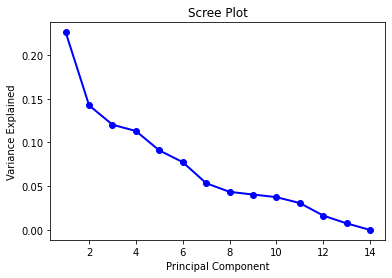

In [39]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [40]:
# get the cumulative variance
cum_var = exp_var.cumsum()

In [41]:
cum_var

array([0.22607828, 0.36855948, 0.48887309, 0.60198984, 0.69288847,
       0.77044049, 0.82388529, 0.86742413, 0.9079162 , 0.94538027,
       0.97612338, 0.99252639, 1.        , 1.        ])

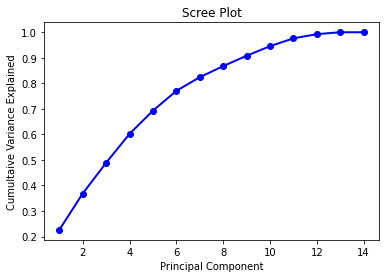

In [42]:
plt.plot(PC_values, cum_var, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumultaive Variance Explained')
plt.show()

Components to capture at least 80% of variance:  7


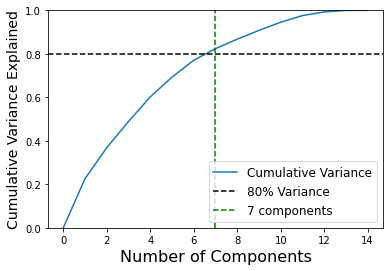

In [43]:
# find the number of components
index_80 = sum(cum_var <= 0.8)

# indices are zero-indexed, so the total number is one more than this
print('Components to capture at least 80% of variance: ', index_80+1)

# add a zero at the start so the plot extends all the way down
cum_var_plot = [0] + list(cum_var)

# plot
fig, ax = plt.subplots()
ax.plot(range(len(cum_var_plot)), cum_var_plot, label = 'Cumulative Variance')

# add some lines to illustrate the question
ax.axhline(0.8, color = 'k', linestyle = '--', label = '80% Variance')
ax.axvline(index_80+1, color = 'g', linestyle = '--', label = str(index_80+1)+ ' components')

# limit the y axes
ax.set_ylim([0, 1])

# axes labels and legend
ax.set_xlabel('Number of Components', fontsize = 16)
ax.set_ylabel('Cumulative Variance Explained', fontsize = 14)
_ = ax.legend(fontsize = 12)

### Scree plots of samples

In [65]:
data_norm

RXN,kf_HEX1,kf_PGI,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ADK1,kf_ATPM,kf_DM_nadh
0,0.004371,0.029062,0.003945,0.029059,0.018186,0.000461,0.022217,0.024414,0.000513,0.008559,0.005347,0.025734,0.010101,0.010346
1,0.004348,0.004328,0.024420,0.071466,0.018479,0.008078,0.078297,0.027918,0.001254,0.010901,0.002846,0.025734,0.024738,0.018240
2,0.004657,0.005066,0.003696,0.030027,0.026898,0.014328,0.006747,0.023953,0.005108,0.003627,0.009653,0.025734,0.024127,0.037918
3,0.002205,0.009615,0.001656,0.072725,0.065003,0.009915,0.008556,0.064808,0.120200,0.003487,0.005055,0.025734,0.010351,0.020102
4,0.001831,0.008361,0.001371,0.031182,0.022809,0.001087,0.013306,0.021228,0.000887,0.004222,0.001629,0.025734,0.007946,0.008309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,0.024527,0.005965,0.003940,0.004191,0.006145,0.000190,0.123655,0.017401,0.001698,0.053744,0.007297,0.025734,0.043797,0.017755
1506,0.030484,0.011287,0.005403,0.005845,0.006502,0.000080,0.057007,0.011180,0.000677,0.025832,0.004114,0.025734,0.032626,0.015421
1507,0.008158,0.010870,0.002172,0.014017,0.005046,0.000045,0.010948,0.009155,0.000205,0.002086,0.002014,0.025734,0.009937,0.018517
1508,0.005294,0.004652,0.002771,0.010699,0.004649,0.000378,0.006714,0.011166,0.000240,0.007697,0.007300,0.025734,0.017643,0.017362


In [81]:
pca = decomposition.PCA().fit(data_norm.T)
# pca.components_

pc_genes = pd.DataFrame(pca.components_.T,
                        # index = data_norm.columns
                        )
pc_genes
# pc_samples = pd.DataFrame(pca.transform(data_norm),
#                           index = data_norm.index)

# # get the explained variance, which will be useful later
exp_var = pca.explained_variance_ratio_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.015467,0.007469,-0.011718,-0.006992,-0.027145,0.019005,0.003679,0.009548,-0.009007,0.012403,0.012581,0.016315,0.013971,0.304962
1,-0.020826,0.010017,-0.020147,0.023252,-0.056146,-0.010119,-0.032751,-0.026386,-0.091381,0.042646,0.016786,-0.009840,0.022088,0.075533
2,-0.008973,0.000163,-0.019909,-0.017706,-0.017447,-0.018786,0.015661,-0.018809,-0.005408,-0.020223,0.035592,-0.001593,-0.037468,-0.055392
3,0.040073,0.090164,0.001253,-0.040718,-0.074036,-0.026322,0.018690,-0.017098,0.006215,-0.032396,-0.016383,-0.008641,-0.040579,-0.152687
4,-0.011862,0.007589,-0.013993,-0.008391,-0.034364,-0.002942,0.004232,-0.003105,-0.006563,-0.004126,0.007495,0.017006,0.023862,-0.237464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,-0.027084,0.010340,-0.002174,0.104830,-0.006789,0.001179,-0.016150,-0.016647,-0.032381,0.089177,0.066080,0.025865,0.004913,-0.001825
1506,-0.019830,-0.001579,0.010277,0.043687,-0.003844,-0.005443,0.004046,0.006300,-0.013661,0.037913,0.046047,0.022539,0.010781,-0.001756
1507,-0.011325,0.001310,-0.003744,-0.006100,-0.007098,-0.000470,0.009926,0.002035,-0.010329,-0.001964,0.036202,0.008120,0.032539,0.009915
1508,-0.011818,0.001330,-0.005309,-0.001995,0.000010,-0.005368,0.011101,-0.004501,-0.007468,-0.014983,0.028478,0.026773,0.013592,0.010205


In [82]:
(pca.n_components_)

14

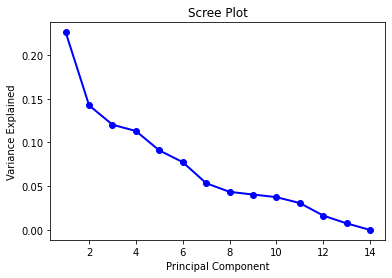

In [83]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
# get the cumulative variance
cum_var = exp_var.cumsum()

In [ ]:
cum_var

array([0.22607828, 0.36855948, 0.48887309, 0.60198984, 0.69288847,
       0.77044049, 0.82388529, 0.86742413, 0.9079162 , 0.94538027,
       0.97612338, 0.99252639, 1.        , 1.        ])

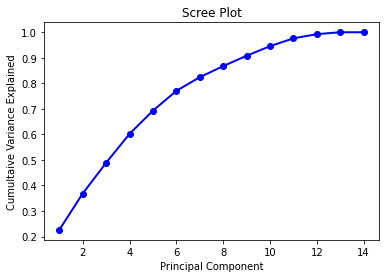

In [ ]:
plt.plot(PC_values, cum_var, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumultaive Variance Explained')
plt.show()

Components to capture at least 80% of variance:  7


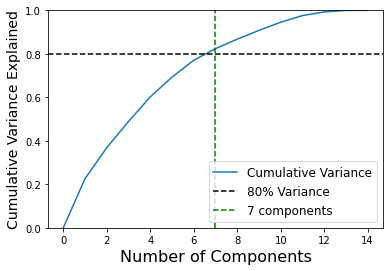

In [ ]:
# find the number of components
index_80 = sum(cum_var <= 0.8)

# indices are zero-indexed, so the total number is one more than this
print('Components to capture at least 80% of variance: ', index_80+1)

# add a zero at the start so the plot extends all the way down
cum_var_plot = [0] + list(cum_var)

# plot
fig, ax = plt.subplots()
ax.plot(range(len(cum_var_plot)), cum_var_plot, label = 'Cumulative Variance')

# add some lines to illustrate the question
ax.axhline(0.8, color = 'k', linestyle = '--', label = '80% Variance')
ax.axvline(index_80+1, color = 'g', linestyle = '--', label = str(index_80+1)+ ' components')

# limit the y axes
ax.set_ylim([0, 1])

# axes labels and legend
ax.set_xlabel('Number of Components', fontsize = 16)
ax.set_ylabel('Cumulative Variance Explained', fontsize = 14)
_ = ax.legend(fontsize = 12)

In [44]:
from sklearn.preprocessing import StandardScaler

In [45]:
df_st =  StandardScaler().fit_transform(percs_df.T)  
pd.DataFrame(df_st, columns=percs_df.T.columns).head(2)

RXN,kf_HEX1,kf_PGI,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ADK1,kf_ATPM,kf_DM_nadh
0,-0.613392,0.604384,-0.764383,0.597987,-0.107238,-0.084724,0.287090,0.287075,-0.125633,-0.392130,-0.529149,0.0,-0.878444,-0.803406
1,-0.614546,-0.731293,0.349041,2.922305,-0.089255,0.212857,3.134338,0.497761,-0.096521,-0.274292,-0.653295,0.0,0.208540,-0.239500


In [46]:
pca_out = PCA().fit(df_st)
pca_out.explained_variance_ratio_
np.cumsum(pca_out.explained_variance_ratio_)
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = percs_df.T.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
variable,,,,,,,,,,,,,,
kf_HEX1,4.711905e-01,-1.734354e-01,7.565149e-02,8.379088e-02,2.069739e-01,4.931696e-02,-1.000063e-01,-3.503736e-01,1.462208e-01,-6.391361e-01,1.265775e-02,-1.352630e-01,-3.298341e-01,0.000000e+00
kf_PGI,7.799132e-02,-1.309843e-01,-1.731531e-01,3.105710e-02,-7.528129e-01,1.042282e-02,4.108158e-01,2.433137e-02,-6.046852e-02,-3.486727e-01,2.249908e-01,2.308593e-03,1.837420e-01,1.276295e-16
kf_PFK,4.820341e-01,-2.028409e-01,-1.434135e-01,3.051627e-02,-3.001708e-01,6.272533e-02,5.785319e-02,-4.116577e-02,-2.292253e-02,5.526042e-01,-2.680633e-01,8.947880e-03,-4.775842e-01,-2.435790e-16
kf_FBA,-5.851048e-02,1.682923e-01,-1.817376e-02,6.736606e-01,-9.711364e-02,-5.821454e-03,-2.073284e-02,2.177880e-01,6.686683e-01,1.193556e-02,-9.237980e-02,-2.973984e-02,-1.003043e-02,1.343064e-16
kf_TPI,5.367074e-02,4.595242e-02,8.421292e-02,7.058591e-01,5.462805e-02,-6.725862e-02,-1.224503e-02,-1.103490e-01,-6.784600e-01,7.663637e-03,-4.426751e-02,-1.546141e-02,8.531640e-02,-2.333487e-16
kf_GAPD,2.967909e-02,-7.973913e-02,-2.697727e-02,4.457771e-02,4.586159e-01,2.272347e-03,8.772070e-01,4.477309e-02,5.166556e-02,5.559361e-02,-3.022269e-02,2.341398e-02,-3.152634e-02,-8.522516e-17
kf_PGK,2.864462e-01,4.583283e-01,3.380223e-01,-1.693108e-02,-1.387662e-02,-7.302971e-02,4.580282e-02,1.494484e-01,-1.873338e-02,1.236088e-01,6.736636e-01,1.812452e-01,-2.471372e-01,6.135993e-16
kf_PGM,-9.738762e-02,4.269162e-01,3.197652e-01,-5.468011e-02,-1.960803e-01,9.378366e-02,1.775948e-01,-7.184375e-01,1.248543e-01,1.455598e-01,-2.040510e-01,-1.287601e-01,1.144166e-01,-2.386995e-16
kf_ENO,-3.659386e-02,6.455497e-02,1.211799e-01,1.869350e-02,-1.699479e-03,9.615644e-01,5.417063e-03,1.973734e-01,-9.517282e-02,-6.417677e-02,-3.304147e-02,-3.941629e-03,-3.976283e-02,-1.936217e-16


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

Generated correlation matrix plot for loadings

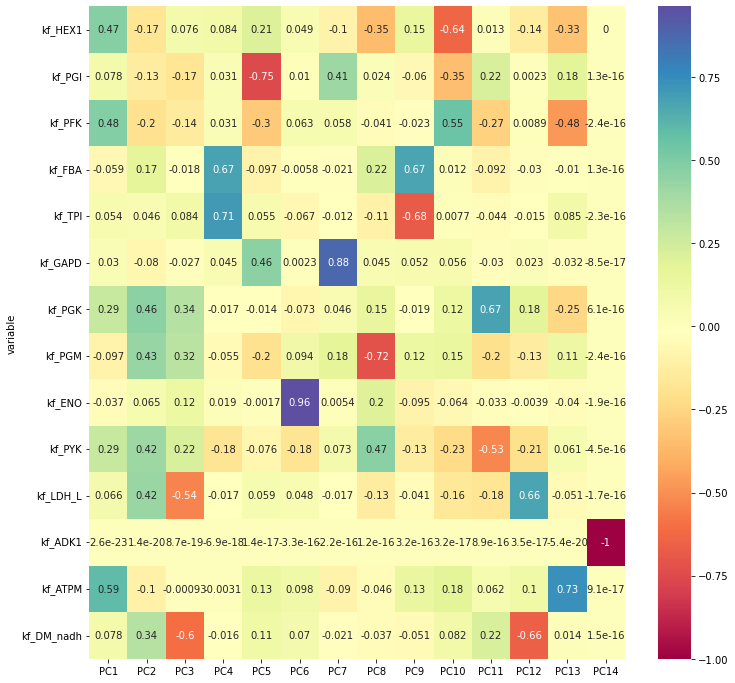

In [49]:
plt.figure(figsize= (12,12))
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
heatmap_sns = os.path.join(data_dir,"gly_heatmap.png")
# Saving figure by changing parameter values
plt.savefig(heatmap_sns, pad_inches=0.3)
plt.show()

In [93]:
from sklearn import cluster, metrics, decomposition

In [103]:
ica = decomposition.FastICA(n_components = None, random_state = 0)
A = ica.fit_transform(data_norm.T).transpose()

# these are the desired matrices
A = pd.DataFrame(A, columns = percs_df.index)
M = pd.DataFrame(ica.mixing_, index = percs_df.columns)

# reconstruct the data
data_norm_reconstructed = M.dot(A)

# compute the explained variance
ica_total_exp_var = metrics.explained_variance_score(
        data_norm, data_norm_reconstructed)
print('M*A explains %.2f%% of the variance in the data.'%(ica_total_exp_var*100))

M*A explains -0.01% of the variance in the data.


c:\Users\sicil\miniconda3\envs\massliver\lib\site-packages\sklearn\decomposition\_fastica.py:494 FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.


Make clusters after ICA

In [110]:
from sklearn.decomposition import FastICA
import matplotlib.cm as cm

def ICA_cluster_plot(data, cluster_labels, ax = None):
    """
    Parameters:
        data: the pd.DataFrame of gene expression data
        cluster_labels: a pd.Series with a cluster label
            for each column of data
        ax: if None, draw a new figure. else, populate these axes.
    Returns:
        ax: the plt.axes object of a PCA plot labeled by cluster
    """
    
    # check for bad input
    if isinstance(cluster_labels, pd.Series):
        if not(cluster_labels.index.equals(data.columns)):
            raise ValueError('cluster_labels.index doesn\'t match data.columns')
    else:
        raise TypeError('cluster_labels isn\'t a pd.Series')
    
    # compute PCA, save as dataframe with condition labels
    # data_norm = stats.zscore(data, axis=1)
    data_norm = sklearn.preprocessing.normalize(data,norm='l2')
    data_pc = FastICA().fit_transform(data_norm.T)
    data_pc = pd.DataFrame(data_pc, index = data.columns)
    
    # get the unique clusters (supports naming if desired)
    unique_clusters = np.sort(cluster_labels.unique())
    
    # prepare a long list of colors
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan',
              'black', 'salmon', 'chocolate', 'orange', 'gold', 'lawngreen',
              'turquoise', 'steelblue', 'navy', 'violet', 'deeppink',
              'firebrick', 'sandybrown','olivedrab','darkgreen', 'aqua',
              'slategray', 'blue', 'fuschia', 'pink']
    
    # this code only runs if you have a ton of labels
    while len(colors) < len(cluster_labels.unique()):
        colors = colors + colors
    
    # make the plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlabel('IC1', fontsize = 16)
    ax.set_ylabel('IC2', fontsize = 16)
    
    # iterate through each cluster label
    for clust, color in zip(unique_clusters, colors):
        
        # get the samples of this cluster
        samples = cluster_labels.index[cluster_labels == clust]
        
        # add to plot
        ax.scatter(data_pc.loc[samples, 0],
                   data_pc.loc[samples, 1],
                   label = clust, color = color)
    
    # add legend
    ax.legend(bbox_to_anchor = (1,0))
    for i in range(data_pc.shape[0]):
        plt.text(x=data_pc.iloc[i,0]+0.1,y=data_pc.iloc[i,1]+0.05,s=data_pc.index[i])
    return ax

In [111]:
k10_clusters = cluster.KMeans(n_clusters =6, random_state = 1)

# compute the clusters
# use the transpose of the data to get samples instead of genes
k10_clusters = k10_clusters.fit(data_log)

# label the output with condition names
k10_labels = pd.Series(k10_clusters.labels_, index = data_log.index)

c:\Users\sicil\miniconda3\envs\massliver\lib\site-packages\sklearn\decomposition\_fastica.py:494 FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.


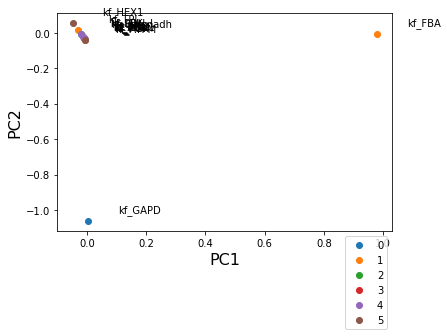

In [112]:
# ANSWER    

ax = ICA_cluster_plot(data_log.T, k10_labels)

In [113]:
data_norm = sklearn.preprocessing.normalize(data_log.T,norm='l2')
data_pc = FastICA().fit_transform(data_norm.T)
data_pc = pd.DataFrame(data_pc, index = data_log.index)
plot_data = data_pc.iloc[:,0:2]
plot_data.columns = ["IC1", "IC2"]
plot_data["RXN"] = plot_data.index
plot_data["clusters"] = k10_labels
alt.data_transformers.disable_max_rows()
fig = alt.Chart(plot_data).mark_circle(size= 100).encode(
    alt.X("IC1", axis=alt.Axis( tickCount=5)),
    alt.Y('IC2',axis=alt.Axis( tickCount=5), ), 

    alt.Color('clusters', scale=alt.Scale(scheme='turbo')), 
    tooltip=['RXN']
).properties(
    width=400,
    height=400).interactive()
fig

c:\Users\sicil\miniconda3\envs\massliver\lib\site-packages\sklearn\decomposition\_fastica.py:494 FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
C:\Users\sicil\AppData\Local\Temp\ipykernel_1796\760841331.py:6 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sicil\AppData\Local\Temp\ipykernel_1796\760841331.py:7 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


alt.Chart(...)

In [108]:
from sklearn.decomposition import NMF
model = NMF(n_components=None, init='random', random_state=0, max_iter = 500)
W = model.fit_transform(data_norm)
H = model.components_

In [109]:
H

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.75432956e-03,
        8.82287872e-02, 0.00000000e+00, 0.00000000e+00, 4.11331918e-05,
        1.21599208e-04, 0.00000000e+00, 0.00000000e+00, 1.18870063e-03,
        0.00000000e+00, 1.42154282e-04],
       [0.00000000e+00, 0.00000000e+00, 4.91015826e-04, 2.19407879e-05,
        0.00000000e+00, 1.67024828e-06, 1.31727972e-01, 1.54083767e-02,
        1.71626912e-07, 6.59006750e-03, 0.00000000e+00, 6.13139344e-04,
        0.00000000e+00, 0.00000000e+00],
       [1.62732787e-03, 0.00000000e+00, 5.03055332e-04, 6.45017592e-04,
        0.00000000e+00, 1.98337345e-01, 0.00000000e+00, 1.96040436e-04,
        5.95522760e-06, 0.00000000e+00, 0.00000000e+00, 3.01031841e-03,
        0.00000000e+00, 1.71696110e-03],
       [0.00000000e+00, 3.71229416e-01, 1.32764419e-02, 0.00000000e+00,
        7.28024571e-04, 4.16312398e-05, 0.00000000e+00, 4.16126014e-03,
        3.13745829e-05, 0.00000000e+00, 0.00000000e+00, 1.84929031e-02,
        0.000

In [53]:
qcqa_model(glycolysis, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)



╒══════════════════════════════════════════════╕
│ MODEL ID: Glycolysis                         │
│ SIMULATABLE: True                            │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ ----------------------                       │
│ DM_nadh: {charge: 2.0}                       │
│ ============================================ │
╘══════════════════════════════════════════════╛


Successfully loaded MassModel 'Glycolysis' into RoadRunner.


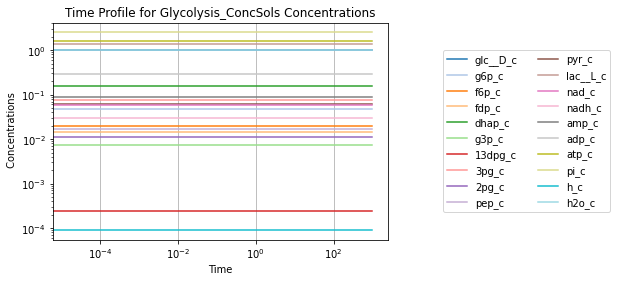

In [54]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [55]:
glycolysis.compartments = {"c": "Cytosol"}
print(glycolysis.compartments)



{'c': 'Cytosol'}


In [56]:
# Using pre-build units to define UnitDefinitions
concentration = UnitDefinition("mM", name="Millimolar",
                               list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

# Add units to model
glycolysis.add_units([concentration, time])
print(glycolysis.units)

[<UnitDefinition Millimolar "mM" at 0x17ef8bb57c0>, <UnitDefinition hour "hr" at 0x17ef8bb55e0>]


In [61]:
from mass.io import json

In [62]:
csv_rbc_glyco = os.path.join(model_dir,"rbc_glyco.json")
json.save_json_model(mass_model=glycolysis, filename=csv_rbc_glyco)

